# SAT Solving for Counterexamples to Conjecture 6

This notebook contains code to use a SAT solver to find counterexamples to Conjecture 6 discussed in the paper "Stable Voting and the Splitting of Cycles". 

In [1]:
%pip install python-sat
%pip install pref_voting

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
from pysat.formula import IDPool
from pysat.solvers import Solver
import itertools
import functools
from pref_voting.weighted_majority_graphs import MarginGraph
from pref_voting.margin_based_methods import split_cycle, stable_voting, simple_stable_voting

In [3]:
pool = IDPool()
n = 7
UNIQUE_SC_WINNER = False
s = Solver(use_timer=True)

# "precedes" variable definitions
def lt(a, b, c, d):
    if a == b or c == d:
        raise ValueError(f'Edges may not be self-loops.')
    if a == c and b == d:
        raise ValueError('Edges must be distinct.')
    if (a > d) or (a == d and b > c):
        return lt(d, c, b, a)
    return pool.id(f'{a}{b}{c}{d}')

# "SSV" variable definitions
def SSV(V, x):
    return pool.id(f"{x}win{''.join(str(v) for v in V)}")

# all undirected edges between a collection of nodes 
def edges(V=range(n)):
    return itertools.permutations(V, 2)


# true if node is reachable from sink with only edges with weight greater than source->sink
def reachable(source, sink, node):
    return pool.id('r:%s,%s,%s' % (source,sink,node))

def scwin(node):
    return pool.id(f'tseitin_scwin_{node}')

# define reachable wrt edge given by source and sink
def reachability(source, sink):
    for (u, v) in edges():
        if (u, v) != (source, sink):
            s.add_clause([-reachable(source,sink,u), -lt(source, sink, u, v), reachable(source, sink, v)])
    s.add_clause([reachable(source, sink, sink)])

# define scwin(i)
def define_winner(i):
    for m in range(n):
        if m != i:
            reachability(m, i)
    # scwin(i) <- [reachable(m,i,m)] for all m != i
    s.add_clause([scwin(i)]+[-reachable(m,i,m) for m in range(n) if i!=m])

# sc winners
def sc_winners():
    for i in range(n):
        define_winner(i)

    if UNIQUE_SC_WINNER:
        for i in range(n):
            for j in range(i+1, n):
                if i != j:
                    s.add_clause([-scwin(i), -scwin(j)])
    s.add_clause([-scwin(0)])

    if n <= 7:
        s.add_clause([scwin(n-1)])


def ordering():
    added = set()
    for ((a, b), (c, d), (e, f)) in itertools.permutations(edges(), 3):
        first = lt(a, b, c, d)
        second = lt(c, d, e, f)
        if (first, second) not in added:
            added.add((first, second))
            s.add_clause([-first, -second, lt(a, b, e, f)])
    for ((a, b), (c, d)) in itertools.permutations(edges(), 2):
        s.add_clause([lt(a, b, c, d), lt(b, a, d, c)])
        s.add_clause([-lt(a, b, c, d), -lt(b, a, d, c)])


def removed(V, x):
    return tuple(v for v in V if v != x)


def SSV_conditions():
    for V in itertools.chain.from_iterable(itertools.combinations(range(n), r) for r in range(1, n+1)):
        s.add_clause([SSV(V, x) for x in V])

        for (x, y) in edges(V):
            s.add_clause([-SSV(V, x), -SSV(V, y)])
        
        for (a, b) in edges(V):
            clause = [-SSV(removed(V, b), a), SSV(V, a)]
            for (c, d) in edges(V):
                if c != a or d != b:
                    # tseitin iff -SSV((removed(V, d), c)) \/ lt(c, d, a, b)
                    tseitin = pool.id(f"t{a}{b}{c}{d}in{''.join(str(x) for x in V)}")
                    s.add_clause([-SSV(removed(V, d), c), lt(c, d, a, b), -tseitin])
                    s.add_clause([SSV(removed(V, d), c), tseitin])
                    s.add_clause([-lt(c, d, a, b), tseitin])
                    clause.append(-tseitin)
            s.add_clause(clause)


def symmetry_breaking():
    for i in range(n):
        V = tuple(range(i+1))
        s.add_clause([SSV(V, 0)])
        for (c, d) in edges(V):
            if c != 0 or d != i:
                s.add_clause([-SSV(removed(V, d), c), lt(c, d, 0, i)])


def check_model(model):
    def compare(x, y):
        (a, b) = x
        (c, d) = y
        return 1 if lt(a, b, c, d) in model else -1 # descending
    edge_list = sorted(edges(), key=functools.cmp_to_key(compare))
    max_weight = (n * (n - 1) // 2)
    return MarginGraph(list(range(n)), 
                       [(edge_list[i][0], edge_list[i][1], max_weight - i) for i in range(len(edge_list) // 2)])


# add the clauses
ordering()
SSV_conditions()
sc_winners()
symmetry_breaking()

if n <= 7:
    s.add_clause([-reachable(n-1, 0, n-1)])

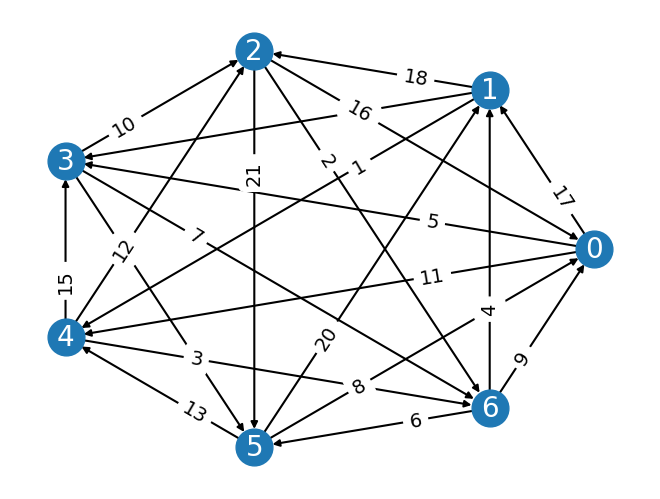

Time: 22.158044
Split Cycle Winners: [2, 4, 6]
Stable Voting Winner: [2]
Simple Stable Voting Winner: [0]


In [4]:
if s.solve():
    result = check_model(s.get_model())
    result.display()
    print(f"Time: {s.time()}")
    print(f"Split Cycle Winners: {split_cycle(result)}")
    print(f"Stable Voting Winner: {stable_voting(result)}")
    print(f"Simple Stable Voting Winner: {simple_stable_voting(result)}")
else:
    print(f"No counterexamples of size {n}")
    print(f"Time: {s.time()}")